In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

# from pulse_lib.pickle_parse import *
# from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
out_chs = [0,1]
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [2]:
freqs = np.arange(21, 3001, 1)

freqs = soccfg.adcfreq(freqs, gen_ch=0, ro_ch=0)

In [3]:
class SingleFreqProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # configure the readout lengths and downconversion frequencies
        for ch in range(2):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"])

        idata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.declare_gen(ch=ch, nqz=1)
            self.add_pulse(ch=ch, name="measure", idata=idata)
        
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency
        self.trigger(pins=[0], t=0) # send a pulse on pmod0_0, for scope trigger
        for ch in self.cfg['out_ch']:
            self.set_pulse_registers(ch=ch, style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], 
                                     waveform="measure", mode="periodic")

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        self.wait_all() # control should wait until the readout is over
        self.sync_all(200)  # wait for measurement to complete

config={"out_ch":out_chs,
        "reps":1000, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks
        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks
        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages
       }

## ADC_D

In [4]:
adc_d_offsets = {}

for freq in freqs:
    config['pulse_freq'] = freq
    prog = SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    d = avg_data[0][0][0] + 1j*avg_data[1][0][0]
    phi_d = np.remainder(np.angle(d,deg=True)+360,360)
    adc_d_offsets[freq] = phi_d
soc.reset_gens()

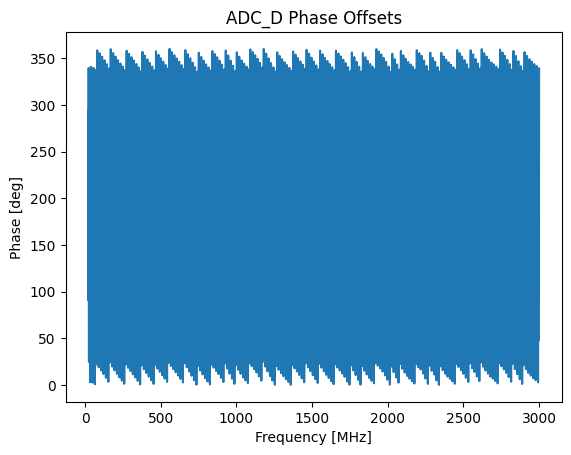

In [5]:
x, y = [], []
for key, value in adc_d_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x, y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_D Phase Offsets");

## ADC_C

In [6]:
adc_c_offsets = {}

for freq in freqs:
    config['pulse_freq'] = freq
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    c = avg_data[0][1][0] + 1j*avg_data[1][1][0]
    phi_c = np.remainder(np.angle(c,deg=True)+360,360)
    adc_c_offsets[freq] = phi_c
soc.reset_gens()

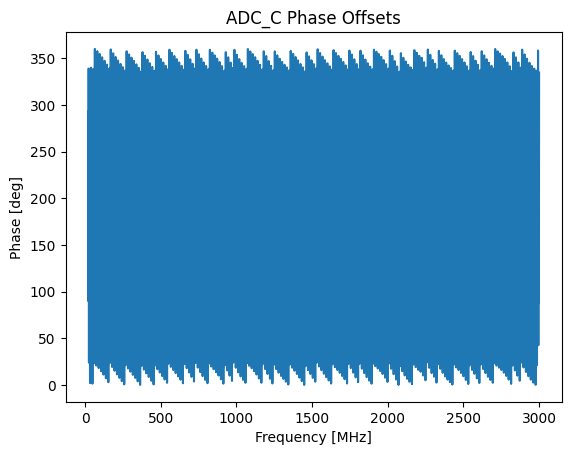

In [7]:
adc_c_x, adc_c_y = [], []
for key, value in adc_c_offsets.items():
    adc_c_x.append(key)
    adc_c_y.append(value)

plt.plot(adc_c_x,adc_c_y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_C Phase Offsets");

In [8]:
adc_offsets = {}

for freq in adc_c_offsets:
    adc_offsets[freq] = ((adc_c_offsets[freq] - adc_d_offsets[freq]) % 360) - 360

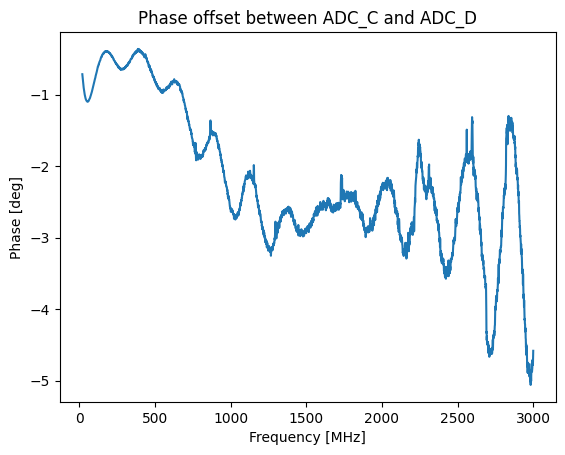

In [9]:
x,y = [], []
for key, value in adc_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between ADC_C and ADC_D");

## Calibrate Phase

In [10]:
delta_phis = {}

for freq in freqs:
    config['pulse_freq'] = freq
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    c = avg_data[0][1][0] + 1j*avg_data[1][1][0]
    phi_c = np.remainder(np.angle(c,deg=True)+360,360)
    d = avg_data[0][0][0] + 1j*avg_data[1][0][0]
    phi_d = np.remainder(np.angle(d,deg=True)+360,360)

    delta_phis[freq] = [(phi_d - phi_c + adc_offsets[freq]) % 360, 0]
soc.reset_gens()

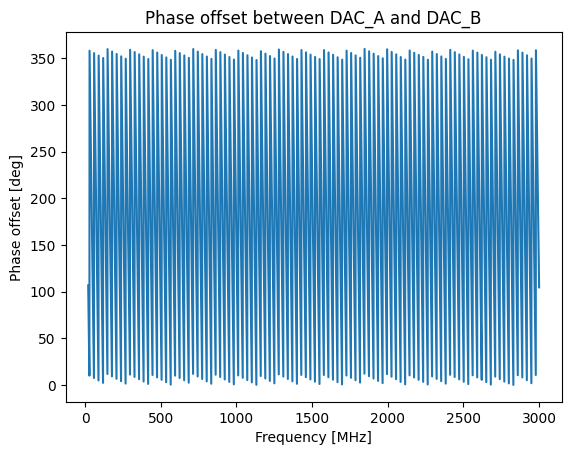

In [11]:
x,y = [], []
for key, value in delta_phis.items():
    x.append(key)
    y.append(value[0])

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [12]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(delta_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)